# Interacting with the ARC Dataset and LLMs

This notebook provides a foundational workflow for exploring the Abstraction and Reasoning Corpus (ARC) dataset using Large Language Models (LLMs).

**Understanding ARC:**

The ARC dataset, created by François Chollet, is designed to test abstract reasoning and intelligence, moving beyond simple pattern recognition. Each ARC task challenges a system to infer an underlying transformation rule from a few examples and then apply that rule to new, unseen inputs.

**Task Structure:**

Every ARC task consists of:
*   **`train` pairs:** A small set (usually 2-5) of input/output grid examples. The goal is to *learn* the transformation rule by observing how the input grids change to become the output grids in these examples.
*   **`test` pairs:** One or more input grids (and their corresponding *unseen* solution output grids). After inferring the rule from the `train` set, the system must apply it to the `test` input grids to generate the correct `test` output grids.

**The Challenge:** The core challenge is the *abstraction* of the rule from the `train` examples and its *generalization* to the `test` inputs.

**Evaluation Rule (ARC Prize):**

For a task to be considered solved:
1.  The system must generate the correct output grid for **every single `test` input grid** within that task.
2.  Each prediction must be an *exact* match to the ground truth solution grid.
3.  If a task has multiple `test` inputs, **all** of them must be solved correctly based on the single rule inferred from the `train` set.

**This Notebook's Goal (Initial Steps):**

This part focuses on the initial setup and data handling:
1.  Setting up the environment (installing and importing libraries).
2.  Performing a basic API call test (assuming credentials are set).
3.  Loading ARC task data from JSON files.
4.  Understanding the structure of the loaded data.
5.  Providing helper functions to easily access specific parts of a task (train pairs, test inputs, test outputs).
6.  Providing visualization tools to inspect tasks.

## 1. Setup: Libraries and API Test

First, we install and import the necessary libraries. We assume you have Python and pip installed.
*   `python-dotenv`: To potentially load API keys from a `.env` file (though we won't explicitly check for the key here).
*   `litellm`: To interact with LLM APIs.
*   `numpy`: For numerical operations and grid comparisons.
*   `matplotlib`: For visualizing the ARC grids.

We'll also perform a minimal API call to ensure `litellm` is configured correctly and can reach the service. **Note:** This step assumes your API key (e.g., `OPENAI_API_KEY`) is already set as an environment variable or globally configured for `litellm`. If not set, this test call will fail.

In [19]:
# Install required packages if they aren't already installed
print("Checking/Installing required libraries...")
try:
    import litellm
    import dotenv
    import numpy
    import matplotlib
    print("Libraries found.")
except ImportError:
    print("Installing python-dotenv, litellm, numpy, matplotlib...")
    %pip install -q python-dotenv litellm numpy matplotlib
    print("Installation complete. You might need to restart the kernel.")

Checking/Installing required libraries...
Libraries found.


In [20]:
import os
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any, Union # Keep typing for clarity

import numpy as np 

from dotenv import load_dotenv
import litellm
from litellm import completion

# --- Visualization Imports --- 
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline 
# --- End Visualization Imports --- 

# Attempt to load environment variables from .env file (optional)
load_dotenv()

# Reduce LiteLLM's default logging verbosity for a cleaner output
litellm.set_verbose = False

print("Libraries imported.")

Libraries imported.


## 1.1 Visualization Setup

Define the standard color map and normalization used for plotting ARC grids. Also define helper functions for displaying grids.

In [21]:
# --- ARC Visualization Constants --- 
ARC_COLORMAP = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'] # Removed white as it's usually not in tasks
)
ARC_NORM = colors.Normalize(vmin=0, vmax=9) # Adjusted vmax based on colormap

# --- Grid Visualization Function (Simplified) --- 
def show_grid(grid, title=None, figsize=None):
    """Displays a single ARC grid using matplotlib."""
    # Assume grid is List[List[int]]
    if not figsize:
        # Basic dynamic sizing, no complex checks
        figsize = (len(grid[0]) * 0.5, len(grid) * 0.5) 
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(np.array(grid), cmap=ARC_COLORMAP, norm=ARC_NORM)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    if title:
        ax.set_title(title, fontsize=10)
    plt.show()

# --- Task Visualization Function (Simplified) --- 
def visualize_task(task_data, task_solutions=None, title="ARC Task"):
    """Plots a task with all train/test input-output pairs."""
    # Assumes task_data structure is {'train': [...], 'test': [...]}
    train_examples = task_data.get('train', [])
    test_examples = task_data.get('test', [])
    has_solution = task_solutions is not None # Check if solutions were provided

    num_train = len(train_examples)
    num_test = len(test_examples)
    total_cols = num_train + num_test
    if total_cols == 0: return # Nothing to plot
    
    # Basic figure sizing
    fig_width = total_cols * 2.5 
    fig_height = 5
    fig, axs = plt.subplots(2, total_cols, figsize=(fig_width, fig_height), squeeze=False)
    plt.suptitle(title, fontsize=14)

    # Plot Train Examples
    for idx, example in enumerate(train_examples):
        axs[0, idx].imshow(np.array(example['input']), cmap=ARC_COLORMAP, norm=ARC_NORM)
        axs[0, idx].set_title(f"Train {idx+1} In")
        axs[0, idx].axis('off')
        axs[1, idx].imshow(np.array(example['output']), cmap=ARC_COLORMAP, norm=ARC_NORM)
        axs[1, idx].set_title(f"Train {idx+1} Out")
        axs[1, idx].axis('off')

    # Plot Test Examples
    for idx, example in enumerate(test_examples):
        col_idx = num_train + idx
        axs[0, col_idx].imshow(np.array(example['input']), cmap=ARC_COLORMAP, norm=ARC_NORM)
        axs[0, col_idx].set_title(f"Test {idx+1} In")
        axs[0, col_idx].axis('off')

        if has_solution and idx < len(task_solutions):
            # Use provided solutions if available
            axs[1, col_idx].imshow(np.array(task_solutions[idx]), cmap=ARC_COLORMAP, norm=ARC_NORM)
            axs[1, col_idx].set_title(f"Test {idx+1} Out")
        elif 'output' in example: # Fallback to output in test data if no separate solutions given
             axs[1, col_idx].imshow(np.array(example['output']), cmap=ARC_COLORMAP, norm=ARC_NORM)
             axs[1, col_idx].set_title(f"Test {idx+1} Out")
        else:
            # If no solution anywhere, show placeholder
            axs[1, col_idx].set_title(f"Test {idx+1} Out: ?")
            axs[1, col_idx].axis('off') # Keep axis off for placeholder too
        axs[1, col_idx].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout slightly for suptitle
    plt.show()

print("Visualization constants and functions defined.")

Visualization constants and functions defined.


In [22]:
# --- Minimal API Key Test --- 
# This performs a very small API call to check basic connectivity.
# It ASSUMES your API key is correctly set in your environment.
# If this cell fails, check your API key setup (e.g., OPENAI_API_KEY env var).
print("Performing minimal API test call...")
try:
    response = completion(
        model="gpt-4o", # Or "gpt-3.5-turbo" or another model you have access to
        messages=[{"role": "user", "content": "Respond with just 'OK'."}],
        max_tokens=2,        # Limit response length
        request_timeout=20 # Short timeout
    )
    # We don't strictly need to check the content, just that it didn't crash
    print("API test call successful (received a response).") 
    # print(f"Test Response: {response.choices[0].message.content}") # Optional: view response
except Exception as e:
    print(f"\033[91mAPI test call failed: {e}\033[0m")
    print("Please ensure your API key (e.g., OPENAI_API_KEY) is set correctly as an environment variable or in a .env file,")
    print("and that you have access to the specified model ('gpt-4o' used here).")

Performing minimal API test call...
API test call successful (received a response).


## 2. Data Loading

This function loads ARC tasks from a specified directory containing `.json` files. It assumes the files are correctly formatted ARC tasks. We are skipping complex error checking for this developer-focused setup.

In [23]:
# --- Type Definitions --- 
# Define types for clarity, even in a simplified script
Grid = List[List[int]] # Represents a 2D grid of integers
TaskPair = Dict[str, Grid] # Represents one {'input': Grid, 'output': Grid} pair
TaskData = Dict[str, List[TaskPair]] # Represents the core content {'train': List[TaskPair], 'test': List[TaskPair]}

def load_arc_tasks_simple(data_dir: str, limit: Optional[int] = None) -> Dict[str, TaskData]:
    """Loads ARC tasks from JSON files into a dictionary (simplified error handling)."""
    arc_path = Path(data_dir)
    # Minimal check: Does the directory exist?
    if not arc_path.is_dir():
        print(f"Error: ARC data directory not found: {arc_path.resolve()}")
        return {}

    # Assume directory scanning works
    json_files = sorted(list(arc_path.glob("*.json")))

    if not json_files:
        print(f"Warning: No JSON files found in {arc_path.resolve()}")
        return {}

    if limit:
        json_files = json_files[:limit]
        # print(f"Limiting loading to the first {len(json_files)} tasks.") # Optional logging

    loaded_tasks: Dict[str, TaskData] = {}
    print(f"Processing {len(json_files)} task files from {arc_path.resolve()}...")

    for json_file in json_files:
        task_id = json_file.stem
        # Assume file is readable and valid JSON with 'train' and 'test' keys
        # No try-except for file read or JSON parsing (chaotic style)
        with open(json_file, 'r', encoding='utf-8') as f:
            task_data = json.load(f)
        loaded_tasks[task_id] = task_data # Store the raw loaded data

    print(f"\nSuccessfully attempted to load {len(loaded_tasks)} tasks.")
    return loaded_tasks

# --- Load the Data --- 
# <<< IMPORTANT: UPDATE THIS PATH TO YOUR ARC DATA DIRECTORY >>>
# Example path structure, adjust as necessary
# For Kaggle environment: 
# ARC_DATA_DIR = "/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges" 
# For local setup (adjust relative/absolute path):
ARC_DATA_DIR = "../ARC-AGI/data/evaluation" # ADJUST THIS PATH!
TASK_LOAD_LIMIT = 20 # Load only a few tasks for faster testing

print(f"\nAttempting to load data from: {Path(ARC_DATA_DIR).resolve()}")
all_task_data: Dict[str, TaskData] = load_arc_tasks_simple(ARC_DATA_DIR, limit=TASK_LOAD_LIMIT)

if not all_task_data:
    print("\n--- CRITICAL: No tasks were loaded. Check ARC_DATA_DIR path. --- ")
else:
    print(f"\nExample Task IDs loaded: {list(all_task_data.keys())[:10]}")


Attempting to load data from: C:\Users\Lukhausen\github\Lepus\experimental\lukas\ARC-AGI\data\evaluation
Processing 20 task files from C:\Users\Lukhausen\github\Lepus\experimental\lukas\ARC-AGI\data\evaluation...

Successfully attempted to load 20 tasks.

Example Task IDs loaded: ['0934a4d8', '135a2760', '136b0064', '13e47133', '142ca369', '16b78196', '16de56c4', '1818057f', '195c6913', '1ae2feb7']


## 3. Understanding ARC Task Data Structure

The `all_task_data` variable loaded above is a Python dictionary.

*   **Keys:** Each key is a string representing the `task_id` (e.g., `'0934a4d8'`).
*   **Values:** Each value is another dictionary (`TaskData`) containing the data for that specific task, loaded directly from the corresponding JSON file.

Inside each `TaskData` dictionary, the crucial keys are:

1.  **`'train'`**: This holds a *list* of training examples.
    *   Each element in the `'train'` list is a dictionary (`TaskPair`).
    *   Each `TaskPair` dictionary has two keys:
        *   `'input'`: Contains the input grid (`Grid`), which is a list of lists of integers (e.g., `[[0, 1], [2, 0]]`).
        *   `'output'`: Contains the corresponding output grid (`Grid`) after the transformation rule has been applied.

2.  **`'test'`**: This holds a *list* of test problems.
    *   Each element in the `'test'` list is also a `TaskPair` dictionary.
    *   Each `TaskPair` in the test list contains:
        *   `'input'`: The test input grid (`Grid`) to which the learned rule must be applied.
        *   `'output'`: The *ground truth* solution grid (`Grid`). The LLM does **not** see this during prediction; it's used for evaluation later.

**LLM Interaction Strategy:**

To ask an LLM to solve *one* test case for a given task, we need to provide:
1.  All the `train` input/output pairs for that task.
2.  The specific `test` input grid we want it to solve.

Since a task can have multiple test cases in its `'test'` list, we typically need to make a separate LLM call for *each* test input grid within that task.

## 4. Helper Functions for Accessing Task Components

To make it easier to prepare data for the LLM, let's create simple functions to extract the relevant pieces from the loaded `TaskData` for a specific task ID.

In [24]:
def get_train_pairs(task_id: str, all_tasks: Dict[str, TaskData]) -> List[TaskPair]:
    """Returns the list of training pairs for a given task ID."""
    # Assumes task_id exists and has 'train' key with a list
    return all_tasks[task_id]['train']

def get_test_inputs(task_id: str, all_tasks: Dict[str, TaskData]) -> List[Grid]:
    """Returns a list of all test input grids for a given task ID."""
    # Assumes task_id exists and has 'test' key with a list of pairs, each having 'input'
    test_pairs = all_tasks[task_id]['test']
    return [pair['input'] for pair in test_pairs]

def get_test_outputs(task_id: str, all_tasks: Dict[str, TaskData]) -> List[Grid]:
    """Returns a list of all test output (solution) grids for a given task ID."""
    # Assumes task_id exists and has 'test' key with a list of pairs, each having 'output'
    test_pairs = all_tasks[task_id]['test']
    return [pair['output'] for pair in test_pairs]

print("Helper functions defined: get_train_pairs, get_test_inputs, get_test_outputs")

Helper functions defined: get_train_pairs, get_test_inputs, get_test_outputs


### Example Usage of Helper Functions

Let's see how to use these functions to get the data components for the first task we loaded.

In [25]:
if all_task_data:
    # Get the first loaded task ID, assume it exists
    example_task_id = list(all_task_data.keys())[0] 
    print(f"--- Example data extraction for Task ID: {example_task_id} ---")

    # Get training pairs
    train_pairs = get_train_pairs(example_task_id, all_task_data)
    print(f"Number of training pairs: {len(train_pairs)}")
    if train_pairs:
        # Print the structure of the first training pair (input/output keys)
        print(f"Structure of first train pair: {train_pairs[0].keys()}") 
        # print(f"First train input grid: {train_pairs[0]['input']}") # Optional: print grid

    # Get test inputs
    test_inputs = get_test_inputs(example_task_id, all_task_data)
    print(f"\nNumber of test inputs: {len(test_inputs)}")
    if test_inputs:
        print(f"Type of first test input: {type(test_inputs[0])}")
        # print(f"First test input grid: {test_inputs[0]}") # Optional: print grid

    # Get test outputs (solutions)
    test_outputs = get_test_outputs(example_task_id, all_task_data)
    print(f"\nNumber of test outputs (solutions): {len(test_outputs)}")
    if test_outputs:
        print(f"Type of first test output: {type(test_outputs[0])}")
        # print(f"First test output grid: {test_outputs[0]}") # Optional: print grid
else:
    print("\nNo task data loaded, skipping example.")

--- Example data extraction for Task ID: 0934a4d8 ---
Number of training pairs: 4
Structure of first train pair: dict_keys(['input', 'output'])

Number of test inputs: 1
Type of first test input: <class 'list'>

Number of test outputs (solutions): 1
Type of first test output: <class 'list'>


### Example: Visualizing a Task

Now let's use the `visualize_task` function to see the structure of the example task.

--- Visualizing Task ID: 0934a4d8 ---


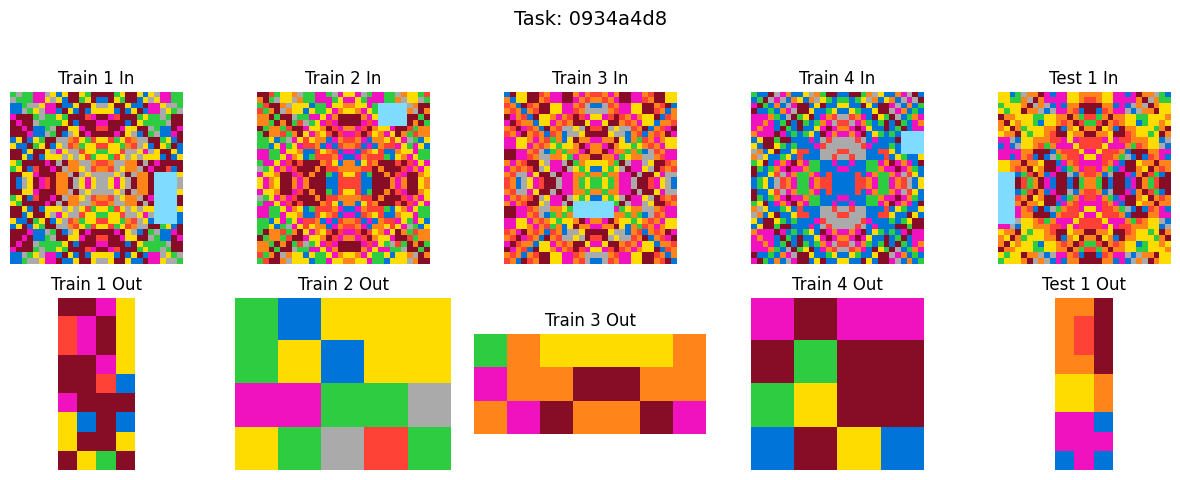

In [26]:
if all_task_data:
    # Use the same example task ID from the previous cell
    example_task_id = list(all_task_data.keys())[0]
    print(f"--- Visualizing Task ID: {example_task_id} ---")
    
    # Get the raw task data dictionary
    task_data_to_visualize = all_task_data[example_task_id]
    
    # Get the ground truth test solutions 
    # Note: visualize_task can also work if task_solutions is None or 
    # if the 'output' keys exist directly in task_data['test']
    ground_truth_solutions = get_test_outputs(example_task_id, all_task_data)
    
    visualize_task(task_data_to_visualize, 
                     task_solutions=ground_truth_solutions, 
                     title=f"Task: {example_task_id}")
else:
    print("\nNo task data loaded, skipping visualization example.")

## 5. Define Prompt Strategy Templates

Instead of complex functions, we can define our prompting strategy using simple string templates with placeholders. We'll use f-string style placeholders like `{placeholder_name}`.

We need placeholders for:
*   `{train_examples_string}`: Where we will insert the formatted string of all training input/output pairs.
*   `{test_input_string}`: Where we will insert the formatted string of the single test input grid we want the LLM to solve.

Below are example templates. You can modify these strings to experiment with different instructions.

In [27]:
# Define simple string templates for the prompts
SYSTEM_PROMPT_TEMPLATE = (
    "You are an ARC puzzle solver. Analyze the train examples (input/output pairs). "
    "Apply the deduced rule to the test input grid. "
    "Output your reasoning and then a JSON array in a Codeblock for the predicted test output grid."
)

USER_PROMPT_TEMPLATE = (
    "**TRAIN EXAMPLES:**\n"
    "{train_examples_string}\n\n"
    "**TEST INPUT GRID:**\n"
    "{test_input_string}\n\n"
    "**PREDICTED OUTPUT GRID:**"
)

print("Prompt templates defined (SYSTEM_PROMPT_TEMPLATE, USER_PROMPT_TEMPLATE).")

Prompt templates defined (SYSTEM_PROMPT_TEMPLATE, USER_PROMPT_TEMPLATE).


## 6. Formatting Helpers and Prompt Preparation

We need helper functions to format the ARC grid data into strings, and then a function to insert these strings into our templates to create the final messages for the LLM API.

In [28]:
# --- Formatting Helpers (Simplified) --- 

def format_grid_to_string(grid: Grid) -> str:
    """Converts a grid (list of lists) to a compact JSON string representation."""
    # Assume grid is a list of lists of ints
    return json.dumps(grid, separators=(',', ':'))

def format_train_pairs_to_string(train_pairs: List[TaskPair]) -> str:
    """Formats a list of training pairs into a single string for the prompt."""
    formatted_pairs = []
    for i, pair in enumerate(train_pairs):
        # Assume 'input' and 'output' keys exist
        input_str = format_grid_to_string(pair['input'])
        output_str = format_grid_to_string(pair['output'])
        formatted_pairs.append(f"Example {i+1} Input:\n{input_str}\nExample {i+1} Output:\n{output_str}")
    return "\n\n".join(formatted_pairs)

# --- Prompt Preparation Function --- 

def prepare_prompt_messages(
    system_template: str,
    user_template: str,
    train_pairs: List[TaskPair],
    test_input_grid: Grid
) -> List[Dict[str, str]]:
    """Formats data and inserts it into prompt templates to create API messages."""

    # Format the training examples and test input into strings
    train_examples_str = format_train_pairs_to_string(train_pairs)
    test_input_str = format_grid_to_string(test_input_grid)

    # Use .format() which is slightly more robust than f-strings if templates are complex
    final_user_prompt = user_template.format(
        train_examples_string=train_examples_str,
        test_input_string=test_input_str
    )
    
    final_system_prompt = system_template # Usually static here

    # Return the structured messages
    messages = [
        {"role": "system", "content": final_system_prompt},
        {"role": "user", "content": final_user_prompt}
    ]
    return messages

print("Formatting and prompt preparation functions defined.")

Formatting and prompt preparation functions defined.


In [29]:
# --- Sample Data for Testing Prompt Preparation --- 
sample_train_pairs: List[TaskPair] = [
    {'input': [[1, 0], [0, 0]], 'output': [[0, 1], [0, 0]]},
    {'input': [[0, 0], [2, 0]], 'output': [[0, 0], [0, 2]]}
]
sample_test_input_grid: Grid = [[0, 3], [0, 0]]

# --- Call the Preparation Function --- 
print("--- Preparing messages using sample data ---")
prepared_messages = prepare_prompt_messages(
    system_template=SYSTEM_PROMPT_TEMPLATE,
    user_template=USER_PROMPT_TEMPLATE,
    train_pairs=sample_train_pairs,
    test_input_grid=sample_test_input_grid
)

# --- Print the Result --- 
print("\nResulting 'messages' list (ready for LLM API):")
print(json.dumps(prepared_messages, indent=2))

# --- Optionally, print the formatted User prompt content for clarity ---
print("\n--- Content of the 'user' message: ---")
print(prepared_messages[1]['content'])
print("--------------------------------------")

--- Preparing messages using sample data ---

Resulting 'messages' list (ready for LLM API):
[
  {
    "role": "system",
    "content": "You are an ARC puzzle solver. Analyze the train examples (input/output pairs). Apply the deduced rule to the test input grid. Output your reasoning and then a JSON array in a Codeblock for the predicted test output grid."
  },
  {
    "role": "user",
    "content": "**TRAIN EXAMPLES:**\nExample 1 Input:\n[[1,0],[0,0]]\nExample 1 Output:\n[[0,1],[0,0]]\n\nExample 2 Input:\n[[0,0],[2,0]]\nExample 2 Output:\n[[0,0],[0,2]]\n\n**TEST INPUT GRID:**\n[[0,3],[0,0]]\n\n**PREDICTED OUTPUT GRID:**"
  }
]

--- Content of the 'user' message: ---
**TRAIN EXAMPLES:**
Example 1 Input:
[[1,0],[0,0]]
Example 1 Output:
[[0,1],[0,0]]

Example 2 Input:
[[0,0],[2,0]]
Example 2 Output:
[[0,0],[0,2]]

**TEST INPUT GRID:**
[[0,3],[0,0]]

**PREDICTED OUTPUT GRID:**
--------------------------------------


## 7. Get LLM Response (Simple)

This function takes the prepared messages and sends them to the specified LLM using `litellm`. It returns the raw text response content, with minimal error handling.

In [30]:
def get_llm_response(messages: List[Dict[str, str]], model_name: str) -> Optional[str]:
    """Sends messages to the LLM and returns the raw response content."""
    # print(f"Sending request to model: {model_name}...") # Reduced verbosity
    try:
        response = completion(
            model=model_name,
            messages=messages,
            temperature=0.0, # Low temp for potentially deterministic output
            max_tokens=2048, # Adjust if needed
            request_timeout=120 # Seconds
        )
        # Assume success and standard response structure - no checks
        response_content = response.choices[0].message.content
        # print("Response received.") # Reduced verbosity
        return response_content
    except Exception as e:
        # Only print error if it happens
        print(f"\033[91mLLM API call failed: {e}\033[0m")
        return None # Return None on failure

print("LLM interaction function 'get_llm_response' defined.")

LLM interaction function 'get_llm_response' defined.


## 7.1 LLM Response Parser

This function attempts to extract a JSON grid (like `[[0,1],[2,0]]`) from the LLM's text response. It prioritizes JSON found within markdown code blocks (like ```json ... ```).

In [31]:
import re # Import the regular expression module

def parse_llm_response_for_grid(response_content: Optional[str]) -> Optional[Grid]:
    """Attempts to find and parse a JSON grid array from the LLM response."""
    if not response_content or not isinstance(response_content, str):
        # print("Parser received empty or non-string content.") # Optional logging
        return None

    response_text = response_content.strip()
    
    # Prioritize ```json [...] ``` blocks
    json_block_match = re.search(r"```json\s*(\[.*?\])\s*```", response_text, re.DOTALL)
    potential_json_str = None
    if json_block_match:
        potential_json_str = json_block_match.group(1).strip()
    else:
        # Fallback to plain ``` [...] ``` blocks
        code_block_match = re.search(r"```\s*(\[.*?\])\s*```", response_text, re.DOTALL)
        if code_block_match:
            potential_json_str = code_block_match.group(1).strip()
        else:
            # Fallback: Find the first plausible JSON array `[...]` anywhere
            first_bracket_match = re.search(r"(\[\s*\[.*?\]\s*\])", response_text, re.DOTALL)
            if first_bracket_match:
                 potential_json_str = first_bracket_match.group(1).strip()

    if not potential_json_str:
        # print("Could not find any potential JSON grid content.") # Optional logging
        return None

    # Attempt to parse the extracted string
    try:
        parsed_grid = json.loads(potential_json_str)
    except json.JSONDecodeError:
        # print(f"JSON decoding failed for extracted string: {potential_json_str[:100]}...") # Optional logging
        return None

    # Basic Validation: Is it a list? (Does not deeply validate content type or shape)
    if not isinstance(parsed_grid, list):
        return None
    # Check if it looks like a grid (list of lists) - minimal check
    if not all(isinstance(row, list) for row in parsed_grid):
         return None
         
    # Optional: Could add a check for integers, but keeping it simple

    # print("Successfully parsed grid.") # Optional logging
    return parsed_grid

print("LLM response parsing function 'parse_llm_response_for_grid' defined.")

LLM response parsing function 'parse_llm_response_for_grid' defined.


## 8. Example: Run Strategy and Compare Output

Let's select a task and a test case, prepare the prompt using our templates, get the LLM's raw response, parse the predicted grid, and print it alongside the ground truth solution for manual comparison.

--- Running Simple Example: Task '0934a4d8', Test Case 0 ---

--- Messages Sent to LLM --- 
[
  {
    "role": "system",
    "content": "You are an ARC puzzle solver. Analyze the train examples (input/output pairs). Apply the deduced rule to the test input grid. Output your reasoning and then a JSON array in a Codeblock for the predicted test output grid."
  },
  {
    "role": "user",
    "content": "**TRAIN EXAMPLES:**\nExample 1 Input:\n[[3,5,3,3,6,6,5,4,1,4,9,9,4,3,9,9,9,9,3,4,9,9,4,1,4,5,6,6,3,3],[5,3,3,3,6,6,4,5,4,1,9,9,3,4,9,1,1,9,4,3,9,9,1,4,5,4,6,6,3,3],[1,1,3,5,5,4,6,6,9,1,1,4,9,9,4,5,5,4,9,9,4,1,1,9,6,6,4,5,5,3],[1,1,5,3,4,5,6,6,1,9,4,1,9,1,4,4,4,4,1,9,1,4,9,1,6,6,5,4,3,5],[6,9,9,9,3,5,3,3,4,3,9,9,9,2,6,9,9,6,2,9,9,9,3,4,3,3,5,3,9,9],[9,6,9,9,5,3,3,3,3,4,9,1,9,9,9,6,6,9,9,9,1,9,4,3,3,3,3,5,9,9],[9,9,6,9,1,1,3,5,9,9,4,4,6,9,9,2,2,9,9,6,4,4,9,9,5,3,1,1,9,6],[9,9,9,6,1,1,5,3,9,1,5,4,9,6,9,9,9,9,6,9,4,5,1,9,3,5,1,1,6,9],[1,4,9,1,4,3,9,9,5,5,7,2,4,3,2,4,4,2,3,4,2,7,5,5,9,9,3,4,1,9]

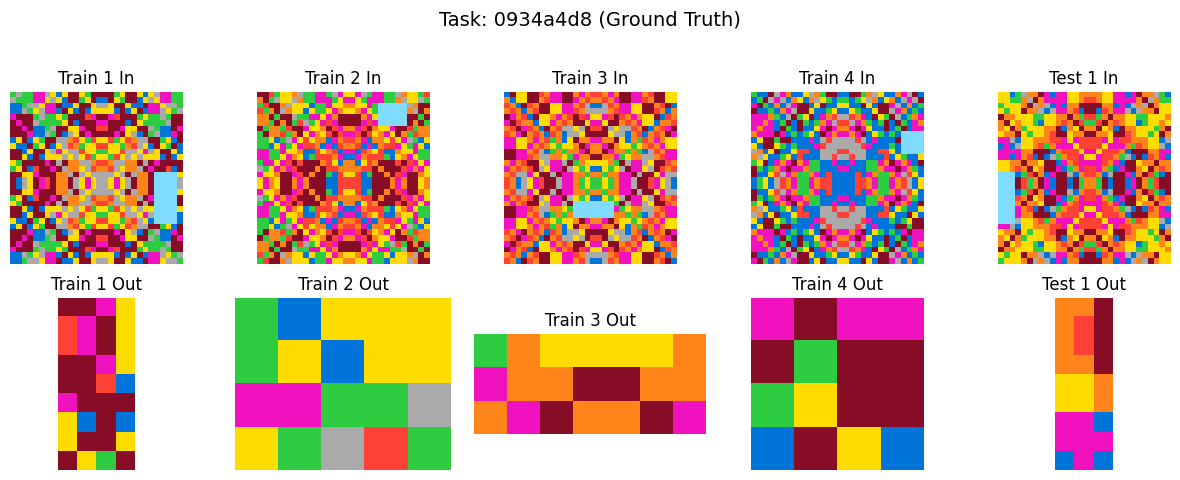


Visualization with LLM Prediction for Test Case 0:


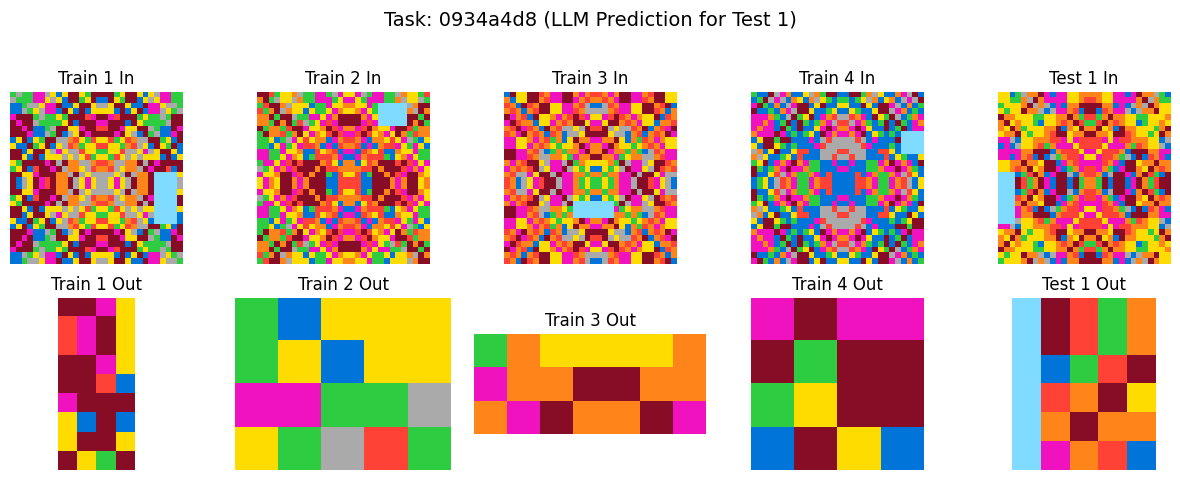

In [33]:
# --- Configuration for Simple Example ---
EXAMPLE_TASK_ID = '0934a4d8' # Choose a task ID that was loaded
TEST_CASE_INDEX = 0          # Which test case within the task (usually 0)
MODEL_NAME = 'gpt-4o'        # The LLM model to use
# --- End Configuration ---

# Check if data is loaded and task exists
if not all_task_data or EXAMPLE_TASK_ID not in all_task_data:
    print(f"\033[91mError: Task data not loaded or Task ID '{EXAMPLE_TASK_ID}' not found.\033[0m")
else:
    print(f"--- Running Simple Example: Task '{EXAMPLE_TASK_ID}', Test Case {TEST_CASE_INDEX} ---")

    # 1. Get Task Data Components
    task_data_dict = all_task_data[EXAMPLE_TASK_ID] # Get the full task data dict
    train_pairs = get_train_pairs(EXAMPLE_TASK_ID, all_task_data)
    test_inputs = get_test_inputs(EXAMPLE_TASK_ID, all_task_data)
    test_outputs_truth = get_test_outputs(EXAMPLE_TASK_ID, all_task_data) # List of all ground truth outputs

    # Check if the test case index is valid (minimal check)
    if TEST_CASE_INDEX >= len(test_inputs):
        print(f"\033[91mError: Test case index {TEST_CASE_INDEX} out of bounds for task '{EXAMPLE_TASK_ID}'.\033[0m")
        parsed_predicted_grid = None # Ensure this is None if index is invalid
    else:
        target_test_input = test_inputs[TEST_CASE_INDEX]
        ground_truth_output_single = test_outputs_truth[TEST_CASE_INDEX] # Ground truth for the specific test case

        # 2. Prepare Prompt Messages using Templates
        messages = prepare_prompt_messages(
            system_template=SYSTEM_PROMPT_TEMPLATE,
            user_template=USER_PROMPT_TEMPLATE,
            train_pairs=train_pairs,
            test_input_grid=target_test_input
        )

        # --- Print the messages being sent to the LLM ---
        print("\n--- Messages Sent to LLM --- ")
        print(json.dumps(messages, indent=2))
        # ------------------------------------------------

        # 3. Get LLM Response
        print(f"\nSending request to model: {MODEL_NAME}...")
        raw_llm_response = get_llm_response(messages, MODEL_NAME)
        print("Response received (or failure logged)." if raw_llm_response is not None else "LLM call failed.")

        # 4. Parse the LLM Response
        print("\n--- Parsing LLM Response ---")
        parsed_predicted_grid = parse_llm_response_for_grid(raw_llm_response) # Prediction for the specific test case

        # 5. Print Raw Response, Parsed Prediction, and Ground Truth for the specific test case
        print("\n--- Comparison for Test Case", TEST_CASE_INDEX, "---")
        # Modified to print the full raw response
        print(f"\nRaw LLM Response:\n```\n{str(raw_llm_response)}\n```" if raw_llm_response else "Raw LLM Response: None")

        if parsed_predicted_grid is not None:
            parsed_grid_string = format_grid_to_string(parsed_predicted_grid)
            print(f"\nParsed Predicted Grid (JSON):\n```json\n{parsed_grid_string}\n```")
        else:
            print("\nParsed Predicted Grid: \033[91mParsing Failed (None)\033[0m")

        # Format ground truth for easy comparison
        ground_truth_string = format_grid_to_string(ground_truth_output_single)
        print(f"\nGround Truth Output (JSON):\n```json\n{ground_truth_string}\n```")

        # 6. Compare parsed grid with ground truth using numpy (robust)
        if parsed_predicted_grid is not None:
            try:
                np_predicted = np.array(parsed_predicted_grid)
                np_truth = np.array(ground_truth_output_single)
                if np_predicted.shape == np_truth.shape and np.array_equal(np_predicted, np_truth):
                     print("\n\033[92mParsed Grid Match: Prediction matches ground truth!\033[0m")
                else:
                     shape_mismatch = "" if np_predicted.shape == np_truth.shape else f" (Shape mismatch: {np_predicted.shape} vs {np_truth.shape})"
                     print(f"\n\033[91mParsed Grid Match: Prediction differs from ground truth.{shape_mismatch}\033[0m")
            except ValueError as e:
                 print(f"\n\033[91mComparison Error: Could not convert/compare grids: {e}\033[0m")
        else:
            print("\nCannot compare parsed grid as parsing failed.")

    # --- Visualization Section ---
    print(f"\n--- Visualizing Task {EXAMPLE_TASK_ID} ---")

    # 7. Visualize Task with Ground Truth Solutions
    print(f"\nVisualization with Ground Truth:")
    visualize_task(task_data_dict,
                     task_solutions=test_outputs_truth, # Use the list of all ground truths
                     title=f"Task: {EXAMPLE_TASK_ID} (Ground Truth)")

    # 8. Visualize Task with LLM's Prediction (for the specific test case)
    print(f"\nVisualization with LLM Prediction for Test Case {TEST_CASE_INDEX}:")
    # Create a list to hold solutions for visualization, starting with ground truths
    import copy
    solutions_for_llm_viz = copy.deepcopy(test_outputs_truth)

    # If prediction exists and index is valid, replace the corresponding ground truth
    # If prediction failed or index was invalid, parsed_predicted_grid will be None
    if TEST_CASE_INDEX < len(solutions_for_llm_viz):
        solutions_for_llm_viz[TEST_CASE_INDEX] = parsed_predicted_grid # Replace with prediction (or None if failed)

    # Visualize using the modified list
    visualize_task(task_data_dict,
                     task_solutions=solutions_for_llm_viz, # Use the list possibly containing the prediction or None
                     title=f"Task: {EXAMPLE_TASK_ID} (LLM Prediction for Test {TEST_CASE_INDEX+1})")

## 9. Benchmark: Run All Loaded Tasks

Now, let's run the LLM solver on all test cases for all the tasks we loaded. This uses concurrent requests to speed things up. **Warning:** This can be slow and may incur significant API costs depending on the number of tasks, test cases, and the chosen model.

In [ ]:
import concurrent.futures
import time
from collections import defaultdict

# --- Benchmarking Configuration ---
MAX_CONCURRENT_REQUESTS = 50  # ADJUST BASED ON API LIMITS! Start lower if unsure.
MODEL_NAME_BENCHMARK = 'gpt-4o' # Model for benchmark
BENCHMARK_TASK_LIMIT = None # Set to an integer to limit tasks, e.g., 5. None runs all loaded tasks.
# --- End Configuration ---

def process_test_case(task_id, test_index, train_pairs, test_input, ground_truth):
    """Processes a single test case for the benchmark (minimal logging)."""
    messages = prepare_prompt_messages(
        system_template=SYSTEM_PROMPT_TEMPLATE,
        user_template=USER_PROMPT_TEMPLATE,
        train_pairs=train_pairs,
        test_input_grid=test_input
    )
    raw_response = get_llm_response(messages, MODEL_NAME_BENCHMARK)
    predicted_grid = parse_llm_response_for_grid(raw_response)
    
    is_correct = False
    api_or_parse_failed = (predicted_grid is None)
    if not api_or_parse_failed:
        try:
            # Use numpy for robust comparison
            np_predicted = np.array(predicted_grid)
            np_truth = np.array(ground_truth)
            if np_predicted.shape == np_truth.shape:
                 is_correct = np.array_equal(np_predicted, np_truth)
        except ValueError: # Handle potential conversion errors during comparison
            api_or_parse_failed = True # Treat comparison error as a failure
            is_correct = False
            
    return {
        "task_id": task_id,
        "test_index": test_index,
        "predicted_grid": predicted_grid, 
        "ground_truth": ground_truth,
        "is_correct": is_correct,
        "api_or_parse_failed": api_or_parse_failed
    }

# --- Main Benchmark Execution ---

print(f"\n--- Starting Benchmark ---")
print(f"Model: {MODEL_NAME_BENCHMARK}")
print(f"Max Concurrent Requests: {MAX_CONCURRENT_REQUESTS}")

tasks_to_process = all_task_data
if BENCHMARK_TASK_LIMIT is not None and BENCHMARK_TASK_LIMIT < len(all_task_data):
    print(f"Limiting benchmark to first {BENCHMARK_TASK_LIMIT} loaded tasks.")
    tasks_to_process = dict(list(all_task_data.items())[:BENCHMARK_TASK_LIMIT])
    
print(f"Tasks to process: {len(tasks_to_process)}")

start_time = time.time()
results = []
total_test_cases = 0
jobs_to_submit = []

# 1. Prepare all jobs (test cases)
if not tasks_to_process:
     print("\033[91mNo tasks loaded or selected for benchmark. Exiting.\033[0m")
else:
    for task_id, task_data in tasks_to_process.items():
        train_pairs = get_train_pairs(task_id, tasks_to_process)
        test_inputs = get_test_inputs(task_id, tasks_to_process)
        test_outputs = get_test_outputs(task_id, tasks_to_process)
        
        for i in range(len(test_inputs)):
            jobs_to_submit.append({
                "task_id": task_id, 
                "test_index": i, 
                "train_pairs": train_pairs, 
                "test_input": test_inputs[i], 
                "ground_truth": test_outputs[i]
            })
            total_test_cases += 1

    print(f"Total test cases to process: {total_test_cases}")

    # 2. Execute jobs in parallel
    processed_count = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_CONCURRENT_REQUESTS) as executor:
        future_to_job = {executor.submit(process_test_case, **job): job for job in jobs_to_submit}
        
        for future in concurrent.futures.as_completed(future_to_job):
            job_info = future_to_job[future]
            try:
                result = future.result() # Get result from thread
                results.append(result)
            except Exception as exc:
                # Catch unexpected errors from the worker function itself
                task_id = job_info['task_id']
                test_index = job_info['test_index']
                print(f"\n\033[91mError in thread for task {task_id}, test {test_index}: {exc}\033[0m")
                # Record as failure
                results.append({ 
                    "task_id": task_id, "test_index": test_index, 
                    "predicted_grid": None, "ground_truth": job_info['ground_truth'], 
                    "is_correct": False, "api_or_parse_failed": True
                })
            
            processed_count += 1
            print(f"Progress: {processed_count}/{total_test_cases} test cases completed.", end='\r')

    print(f"\nProgress: {processed_count}/{total_test_cases} test cases completed.") 
    end_time = time.time()
    print(f"Benchmark finished in {end_time - start_time:.2f} seconds.")

    # 3. Evaluate Results
    correct_test_cases = 0
    failed_test_cases = 0 # API call, parsing, or comparison failed
    task_results = defaultdict(lambda: {'correct': 0, 'total': 0, 'failed': 0})

    for result in results:
        task_id = result['task_id']
        task_results[task_id]['total'] += 1
        if result['api_or_parse_failed']:
            failed_test_cases += 1
            task_results[task_id]['failed'] += 1
        elif result['is_correct']:
            correct_test_cases += 1
            task_results[task_id]['correct'] += 1

    tasks_solved = 0
    tasks_attempted = len(tasks_to_process)

    for task_id, counts in task_results.items():
        # Task solved = ALL test cases processed successfully AND were correct
        if counts['failed'] == 0 and counts['correct'] == counts['total'] and counts['total'] > 0:
             tasks_solved += 1

    # 4. Print Summary
    print("\n--- Benchmark Results ---")
    print(f"Tasks Attempted: {tasks_attempted}")
    print(f"Total Test Cases: {total_test_cases}")
    print(f"Test Cases Correctly Solved: {correct_test_cases}")
    print(f"Test Cases Failed (API/Parse/Compare): {failed_test_cases}")

    if total_test_cases > 0:
        attempted_for_eval = total_test_cases - failed_test_cases
        if attempted_for_eval > 0:
            test_case_success_rate = (correct_test_cases / attempted_for_eval) * 100
            print(f"Test Case Success Rate (Correct / Successfully Processed): {test_case_success_rate:.2f}%")
        else:
            print("Test Case Success Rate: N/A (All attempts failed processing)")
            
        overall_test_case_accuracy = (correct_test_cases / total_test_cases) * 100
        print(f"Overall Test Case Accuracy (Correct / Total): {overall_test_case_accuracy:.2f}%")

    print(f"\nTasks Solved (All Test Cases Correct): {tasks_solved}")
    if tasks_attempted > 0:
        task_success_rate = (tasks_solved / tasks_attempted) * 100
        print(f"Task Success Rate: {task_success_rate:.2f}%")
    else:
        print("Task Success Rate: N/A")